## Tutorial 5: ABC for image reconstruction

In [1]:
import plotly.io as pio
# Set Plotly to render plots as interactive in notebooks
pio.renderers.default = "notebook"

In this tutorial, you will learn how to use the *Artificial Bee Colony (ABC)* algorithm for an image reconstruction task. Instead of optimizing benchmark functions, we apply *ABC* to reconstruct a target image from the *FashionMNIST* dataset.

FashionMNIST is a dataset of grayscale images with dimensions 28x28 pixels. Each image can be hence represented as a point in $\mathbb{R}^{784}$, 
where each dimension corresponds to a pixel intensity value in the range $[0, 255]$ (in this tutorial, all the images will be normalized in the range $[0, 1]$).

Given a target image $\textbf{t}$, the goal is to find a point $\mathbf{x} \in \mathbb{R}^{784}$ that minimizes the reconstruction error,defined as:

$$\text{Err}(\textbf{x}) = \sum_{i,j} (x_{i,j} - t_{i,j})^2$$

In [2]:
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image as IPImage
from io import BytesIO

First, we download the FashionMNIST dataset and visualize our target image.

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.FashionMNIST(root='../_static/MNISTdata', train=True, download=True, transform=transform)

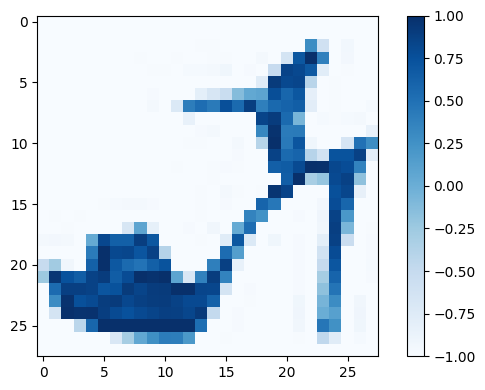

In [4]:
image_index = 9
target_image = train_data[image_index][0].flatten().numpy()
fig, ax = plt.subplots(figsize=(6, 4))
cax = ax.imshow(target_image.reshape(28,28), cmap='Blues')
fig.colorbar(cax)
fig.tight_layout()

Let's define the objective function for the *ABC* algorithm.

In [5]:
def reconstruction_error(x,target=target_image):
    """_summary_
    Args:
        x (numpy array)     : vector encoding a candidate image
        target (numpy array): vector encoding the target image
    Returns:
        float: the reconstruction error
    """
    return np.sum((x - target) ** 2)

In [6]:
from beeoptimal import ArtificialBeeColony

ABC = ArtificialBeeColony(
    colony_size = 100,
    function    = reconstruction_error,
    bounds      = np.array([(0.0, 1.0)] * 784)
    )


ABC.optimize(verbose=True,mutation='ABC/best/1',max_iters=4000)

Running Optimization: 100%|██████████|[00:21<00:00]


In [7]:
# List to store plotly figures
plots = []
# Adaptive step in order to have gifs with same number of frames
step = max(1, (ABC.actual_iters + 1) // 50)  # Note: actual_iters +1 to include initial population
# Generate plotly frames
for iteration in range(0, (ABC.actual_iters +step), step):  # Note: actual_iters +step be sure including the final population
    fig, ax = plt.subplots(figsize=(6,4))
    cax = ax.imshow(ABC.optimal_bee_history[iteration].position.reshape(28, 28), cmap='Blues')
    fig.colorbar(cax)
    ax.set_title(f"Iteration {iteration}")
    fig.tight_layout()
    plt.close(fig)
    plots.append(fig)
    
    
images = []
for fig in plots:
    # Save each figure to a BytesIO object in memory instead of a file
    img_buf = BytesIO()
    #fig.write_image(img_buf, format="png", scale=3)  # Save the Plotly figure as PNG into the buffer
    fig.savefig(img_buf, format="png",dpi=100)       # Matplotlib version
    img_buf.seek(0)  # Rewind the buffer to the start
    images.append(Image.open(img_buf))  # Open the image from the buffer
    
# Create the GIF
#gif_path = tempfile.mktemp(suffix=".gif")
gif_path = '../_static/image_reconstruction.gif'
images[0].save(gif_path, save_all=True, append_images=images[1:], duration=200, loop=0)
IPImage(url=gif_path)